In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag
import time
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
from Datavis import *


from pymatching import Matching

def repetition_code(n):
    """
    Parity check matrix of a repetition code with length n.
    """
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    data = np.ones(2*n, dtype=np.uint8)
    return csc_matrix((data, (row_ind, col_ind)))


def toric_code_x_stabilisers(L):
    """
    Sparse check matrix for the X stabilisers of a toric code with 
    lattice size L, constructed as the hypergraph product of 
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
            [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)

def toric_code_z_stabilisers(L):
    """
    Sparse check matrix for the Z stabilisers of a toric code with 
    lattice size L, constructed as the hypergraph product of 
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
            [kron(eye(Hr.shape[0]), Hr), kron(Hr.T, eye(Hr.shape[1]))],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)

def toric_code_x_logicals(L):
    """
    Sparse binary matrix with each row corresponding to an X logical operator 
    of a toric code with lattice size L. Constructed from the 
    homology groups of the repetition codes using the Kunneth 
    theorem.
    """
    H1 = csc_matrix(([1], ([0],[0])), shape=(1,L), dtype=np.uint8)
    H0 = csc_matrix(np.ones((1, L), dtype=np.uint8))
    x_logicals = block_diag([kron(H1, H0), kron(H0, H1)])
    x_logicals.data = x_logicals.data % 2
    x_logicals.eliminate_zeros()
    return csc_matrix(x_logicals)

def toric_code_z_logicals(L):
    """
    Sparse binary matrix with each row corresponding to a Z logical operator 
    of a toric code with lattice size L. Constructed from the 
    homology groups of the repetition codes using the Kunneth 
    theorem.
    """
    H1 = csc_matrix(([1], ([0],[0])), shape=(1,L), dtype=np.uint8)
    H0 = csc_matrix(np.ones((1, L), dtype=np.uint8))
    z_logicals = block_diag([kron(H0, H1), kron(H1, H0)])
    z_logicals.data = z_logicals.data % 2
    z_logicals.eliminate_zeros()
    return csc_matrix(z_logicals)


def inv_arrange_x_syndrome(syndrome):
    L = int(np.sqrt(len(syndrome)))
    syndrome = syndrome.reshape((L, L))
    # bring last row to the top
    syndrome = np.roll(syndrome, -1, axis=0)
    syndrome = syndrome.flatten()
    return syndrome

## Load Data

In [2]:
code_distance = 5
error_rate = 1

observations = 70000

dataset = np.load(f'test-datasets/HL_data_{code_distance}_{error_rate}_{observations}.npy')

nontest, test = np.split(dataset, [60000])

nontest_data = nontest[:, :code_distance**2 *2]
# last 4 columns are the labels
nontest_labels= nontest[:, -4:]

test_data = test[:, :code_distance**2 *2]
test_labels= test[:, -4:]


nontest_data = np.array(nontest_data)
test_data = np.array(test_data)

print(nontest_data.shape)
print(test_data.shape)




(60000, 50)
(10000, 50)


## Preprocess Data

In [3]:
# init new 
batch_synx = []
batch_synz = []

batch_logx = []
batch_logz = []

for observation in test_data:
    syn0 = observation

    synx = inv_arrange_x_syndrome(syn0[:code_distance**2])
    synz = syn0[code_distance**2:]

    batch_synx.append(synx)
    batch_synz.append(synz)

for label in test_labels:
    logx = label[:2]
    logz = label[2:]

    batch_logx.append(logx)
    batch_logz.append(logz)


batch_synx = np.array(batch_synx)
batch_synz = np.array(batch_synz)
batch_logx = np.array(batch_logx)
batch_logz = np.array(batch_logz)

## Init Matching Vars

In [4]:
err = 155/1000

Hx = toric_code_x_stabilisers(code_distance)
Hz = toric_code_z_stabilisers(code_distance)
Lx = toric_code_x_logicals(code_distance)
Lz = toric_code_z_logicals(code_distance)


matchingx = Matching.from_check_matrix(Hx, weights=np.log((1-err)/err), faults_matrix=Lx)
matchingz = Matching.from_check_matrix(Hz, weights=np.log((1-err)/err), faults_matrix=Lz)


## Actual Matching Algo big important

In [5]:
start_time = time.time()

predicted_observablesx = matchingx.decode_batch(batch_synx)
predicted_observablesz = matchingz.decode_batch(batch_synz)

predicted_observablesx = np.array(predicted_observablesx)
predicted_observablesz = np.array(predicted_observablesz)

predicted_observables = np.concatenate((predicted_observablesx, predicted_observablesz), axis=1)

predicted_observables = np.array([int(''.join(map(str,single_label)),2) for single_label in predicted_observables])
actual_observables = np.array([int(''.join(map(str,single_label)),2) for single_label in test_labels])

print(predicted_observables)

with open(f"al/scores/pr_{code_distance}_{error_rate}.txt", "w") as f:
    for i in range(len(predicted_observables)):
        f.write(f"{predicted_observables[i]}\n")

with open(f"al/scores/ar_{code_distance}_{error_rate}.txt", "w") as f:
    for i in range(len(actual_observables)):
        f.write(f"{actual_observables[i]}\n")


[ 3  8  0 ...  2  0 11]


In [6]:


total_time = time.time() - start_time

with open(f'al/scores/ti_{code_distance}_{error_rate}.txt', 'a') as f:
    f.write(f'{total_time}\n')


## Analy


In [7]:

errors = np.sum(np.any(predicted_observablesx != batch_logx, axis=1)) + np.sum(np.any(predicted_observablesz != batch_logz, axis=1))
print(f'Errors: {errors}')

Errors: 5073


In [8]:
accuracy = 1-(errors / len(test_data))
print(f"Accuracy = {accuracy}")

with open(f'al/scores/ac_{code_distance}_{error_rate}.txt', 'a') as f:
    f.write(f"{accuracy}\n")

Accuracy = 0.4927


In [9]:
test_labels_encoded = np.array([int(''.join(map(str,single_label)),2) for single_label in test_labels])

print(test_labels[:10])
print(test_labels_encoded[:10])

[[0 0 1 1]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [1 0 0 1]
 [0 1 1 0]
 [0 0 0 1]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
[3 8 0 2 9 6 1 0 8 8]


In [10]:
all_pred_labels = np.hstack((predicted_observablesx, predicted_observablesz))
labels_pred_dec = np.array([int(''.join(map(str,single_label)),2) for single_label in all_pred_labels])

Confusion matrix, without normalization


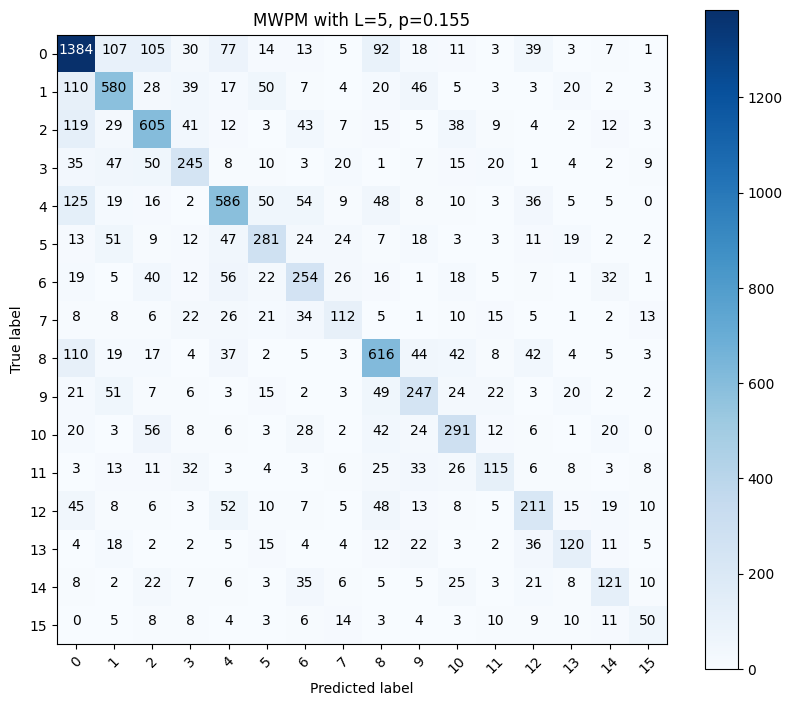

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=f'MWPM with L={code_distance}, p={0.155/error_rate}',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # make bigger
    plt.gcf().set_size_inches(8, 8)

    #plt.savefig(f"cms/cm_L_{code_distance}_p_{error_rate}.png")

    
    plt.show()



cm = confusion_matrix(test_labels_encoded, labels_pred_dec)
if cm.shape[0] < 16:
    cm = np.pad(cm, (0, 16-cm.shape[0]), 'constant')
plot_confusion_matrix(cm, range(16))


In [12]:
# calculate the per class f1 score
cm = confusion_matrix(test_labels_encoded, labels_pred_dec)
def f1_score(cm):
    f1 = []
    for i in range(len(cm)):
        tp = cm[i][i]
        fp = np.sum(cm[:,i]) - tp
        fn = np.sum(cm[i,:]) - tp
        f1.append(tp/(tp + 0.5*(fp + fn)))
    return f1

f1_scores = f1_score(cm)

print(f1_scores)

# save to file
with open(f"al/scores/f1_{code_distance}_{error_rate}.txt", "a") as f:
    f.write(f'{f1_scores}\n')


[0.7037884566488686, 0.6098843322818086, 0.6253229974160207, 0.5157894736842106, 0.610098906819365, 0.5445736434108527, 0.48987463837994216, 0.4155844155844156, 0.6269720101781171, 0.5077081192189106, 0.5521821631878557, 0.42830540037243947, 0.4662983425414365, 0.4743083003952569, 0.44567219152854515, 0.373134328358209]


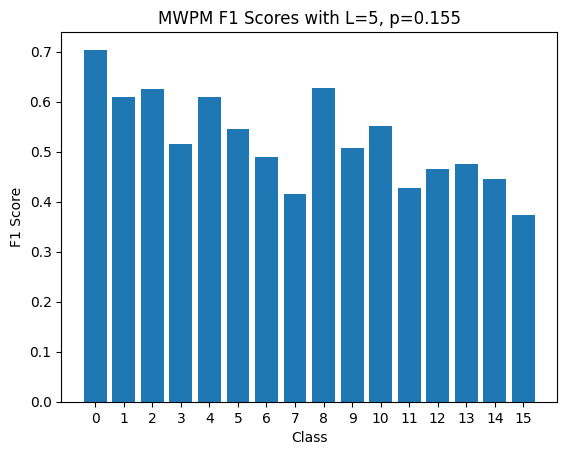

In [13]:


# plot the f1 score
plt.bar(range(cm.shape[0]), f1_score(cm))
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title(f'MWPM F1 Scores with L={code_distance}, p={0.155/error_rate}')
plt.xticks(range(cm.shape[0]))
plt.show()